# Watershed Delineation and Geomorphological Parameter Derivation

This Jupyter Notebook executes the core geospatial analysis steps to delineate the watersheds within the defined study region and compute their relevant geomorphological characteristics. Utilizing the preprocessed Digital Elevation Model (DEM) data (specifically, the sink-filled 1 arc-second tiles organized as VRTs) prepared in the previous notebook, the workflow involves standard hydrological terrain analysis techniques. This typically begins with computing flow direction and flow accumulation grids across the DEM surface. Watershed boundaries are then automatically delineated based on these flow grids, using predefined pour points corresponding to the locations of stream gauge stations. 

In [3]:
# Import libraries
import sys
import geopandas as gpd
from shapely import geometry, ops
from shapely.geometry import shape, Point
from pathlib import Path
import pandas as pd
import numpy as np
import rasterio
from rasterio.windows import Window
from pysheds.grid import Grid
from pyproj import Transformer
from scipy.ndimage import label
from pysheds.view import Raster, ViewFinder
import json
from plotnine import *
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.colors as mcolors
import random
import math
from tqdm.notebook import tqdm
import importlib
import gc


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
# Set paths
project_root_path = Path.cwd().parent.parent
streamflow_gauge_path = project_root_path / 'data' / 'silver' / 'geo' / 'gpkg' / 'study_area_stream_gauge_stn.gpkg'
vrt = project_root_path /'data' / 'silver' / 'geo' / 'raster' / 'dem1arcsec_filled' / 'dem1arcsec.vrt'

In [5]:
# Add path to custom modules
sys.path.append(str(project_root_path/'src'))
from preprocessing.get_utm_epsg import get_nad83_utm_epsg
import preprocessing.delineate_watershed as dws


## Pour Points - Stream Gauge Stations

In this section, stream gauge station is loaded, and  its coordinates extracted. To ensure consistent CRS across files, stream gauge stations CRS will be verified.

In [6]:
streamflow_stn = gpd.read_file(streamflow_gauge_path)
print(f'Streamflow Datum:{streamflow_stn.crs.datum}')
streamflow_stn.head()

Streamflow Datum:North American Datum 1983


,STAID,STANAME,ST,HUC,CLASS,FLOW,STAGE,TIME,TIME_UTC,URL,DATUM,COUNT,PERCENTILE,FLOODSTAGE,geometry
0,03165000,"CHESTNUT CREEK AT GALAX, VA",va,05050001,5,59.4,1.56,2025-02-02 12:00:00,2025-02-02,https://waterdata.usgs.gov/monitoring-location...,NAD83,79,39.50,7.0,POINT (-80.91924 36.64596)
1,03164000,"NEW RIVER NEAR GALAX, VA",va,05050001,0,0.0,2.18,2025-02-02 12:30:00,2025-02-02,https://waterdata.usgs.gov/monitoring-location...,NAD83,94,74.20,9.0,POINT (-80.97897 36.64735)
2,03165500,"NEW RIVER AT IVANHOE, VA",va,05050001,6,3690.0,4.26,2025-02-02 12:50:00,2025-02-02,https://waterdata.usgs.gov/monitoring-location...,NAD83,77,81.30,16.0,POINT (-80.95258 36.83485)
3,03161000,"SOUTH FORK NEW RIVER NEAR JEFFERSON, NC",nc,05050001,5,429.0,2.48,2025-02-02 12:30:00,2025-02-02,https://waterdata.usgs.gov/monitoring-location...,NAD83,97,53.41,8.0,POINT (-81.40695 36.39334)
4,03208500,"RUSSELL FORK AT HAYSI, VA",va,05070202,7,1490.0,4.60,2025-02-02 12:45:00,2025-02-02,https://waterdata.usgs.gov/monitoring-location...,NAD83,97,93.29,16.0,POINT (-82.2957 37.20706)


#### Verify  CRS

The CRS for the original streamflow stations shapefile is **WGS84**. However, by the column `DATUM` is **NAD83**. In notebook [4_streaflow_download.ipynb](notebooks/data_donwload/4_streaflow_download.ipynb), coordinates was downloaded and saved locally from official USGS. Those coordinate will  be used to validate coordinates for the location stations imported above. 

In [7]:
sstn_info_path = project_root_path / 'data/silver/tabular/streamflow/streamflow_stations_info.parquet'
sstn_info = pd.read_parquet(sstn_info_path)
sstn_info.head()    

,site_no,parameter_cd,start_date,end_date,record_count,latitude,longitude,datum
0,03165000,00060,1990-10-01,2025-05-15,12645.0,36.645961,-80.919244,NAD83
1,03164000,00060,1990-10-01,2025-05-15,12645.0,36.647350,-80.978969,NAD83
2,03165500,00060,1996-01-25,2025-05-15,10703.0,36.834845,-80.952581,NAD83
3,03161000,00060,1985-10-01,2025-05-15,14471.0,36.393333,-81.406944,NAD83
4,03208500,00060,1990-10-01,2024-10-01,12419.0,37.207054,-82.295699,NAD83


In [6]:
# Compare location - both file are indicated to be in same datum: NAD83
streamflow_stn['lat'] = streamflow_stn.geometry.y
streamflow_stn['lon'] = streamflow_stn.geometry.x

compare_df = pd.merge(streamflow_stn, sstn_info, how='left', left_on='STAID', right_on='site_no')
compare_df['lat_dif'] = compare_df['lat'] - compare_df['latitude']
compare_df['lon_dif'] = compare_df['lon'] - compare_df['longitude']
compare_df =  compare_df[['site_no','lat_dif', 'lon_dif']]
compare_df.head()

,site_no,lat_dif,lon_dif
0,03165000,0.000001,3.894964e-07
1,03164000,0.000001,3.919413e-07
2,03165500,0.000001,4.977184e-07
3,03161000,0.000003,-4.261743e-06
4,03208500,0.000003,-2.262783e-06


From above, latitude and longitude coordinates are the same for both files.

#### Drop No Data Stations

In [7]:
# Get list of valid data stations id
sstn_historical_data_dir = project_root_path / 'data/bronze/tabular/streamflow'
sstn_list = sstn_historical_data_dir.glob('*.parquet')
sstn_codes = [code.stem.replace('streamflow_','') for code in sstn_list]

valid_stns_bool = streamflow_stn['STAID'].isin(sstn_codes)
valid_stns = streamflow_stn[valid_stns_bool]
valid_stns.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 706 entries, 0 to 1055
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   STAID       706 non-null    object        
 1   STANAME     706 non-null    object        
 2   ST          706 non-null    object        
 3   HUC         705 non-null    object        
 4   CLASS       706 non-null    int32         
 5   FLOW        706 non-null    float64       
 6   STAGE       706 non-null    float64       
 7   TIME        704 non-null    object        
 8   TIME_UTC    706 non-null    datetime64[ms]
 9   URL         706 non-null    object        
 10  DATUM       706 non-null    object        
 11  COUNT       706 non-null    int32         
 12  PERCENTILE  706 non-null    float64       
 13  FLOODSTAGE  706 non-null    float64       
 14  geometry    706 non-null    geometry      
 15  lat         706 non-null    float64       
 16  lon         706 non-nu

In [8]:
# Drop Unecessary columns 
valid_stns = valid_stns[['STAID','STANAME', 'geometry']]

# Merge with station info
valid_stns = valid_stns.merge(right=sstn_info[sstn_info.columns[0:5]], left_on='STAID', right_on='site_no').drop(columns=['STAID'])
valid_stns.head()

,STANAME,geometry,site_no,parameter_cd,start_date,end_date,record_count
0,"CHESTNUT CREEK AT GALAX, VA",POINT (-80.91924 36.64596),03165000,00060,1990-10-01,2025-05-15,12645.0
1,"NEW RIVER NEAR GALAX, VA",POINT (-80.97897 36.64735),03164000,00060,1990-10-01,2025-05-15,12645.0
2,"NEW RIVER AT IVANHOE, VA",POINT (-80.95258 36.83485),03165500,00060,1996-01-25,2025-05-15,10703.0
3,"SOUTH FORK NEW RIVER NEAR JEFFERSON, NC",POINT (-81.40695 36.39334),03161000,00060,1985-10-01,2025-05-15,14471.0
4,"RUSSELL FORK AT HAYSI, VA",POINT (-82.2957 37.20706),03208500,00060,1990-10-01,2024-10-01,12419.0


In [50]:
# Load style configuration for maps
map_style_path = project_root_path / 'config' / 'map_style.json'
with open(map_style_path, 'r') as f:
    map_style = json.load(f).get('map_styles',[])

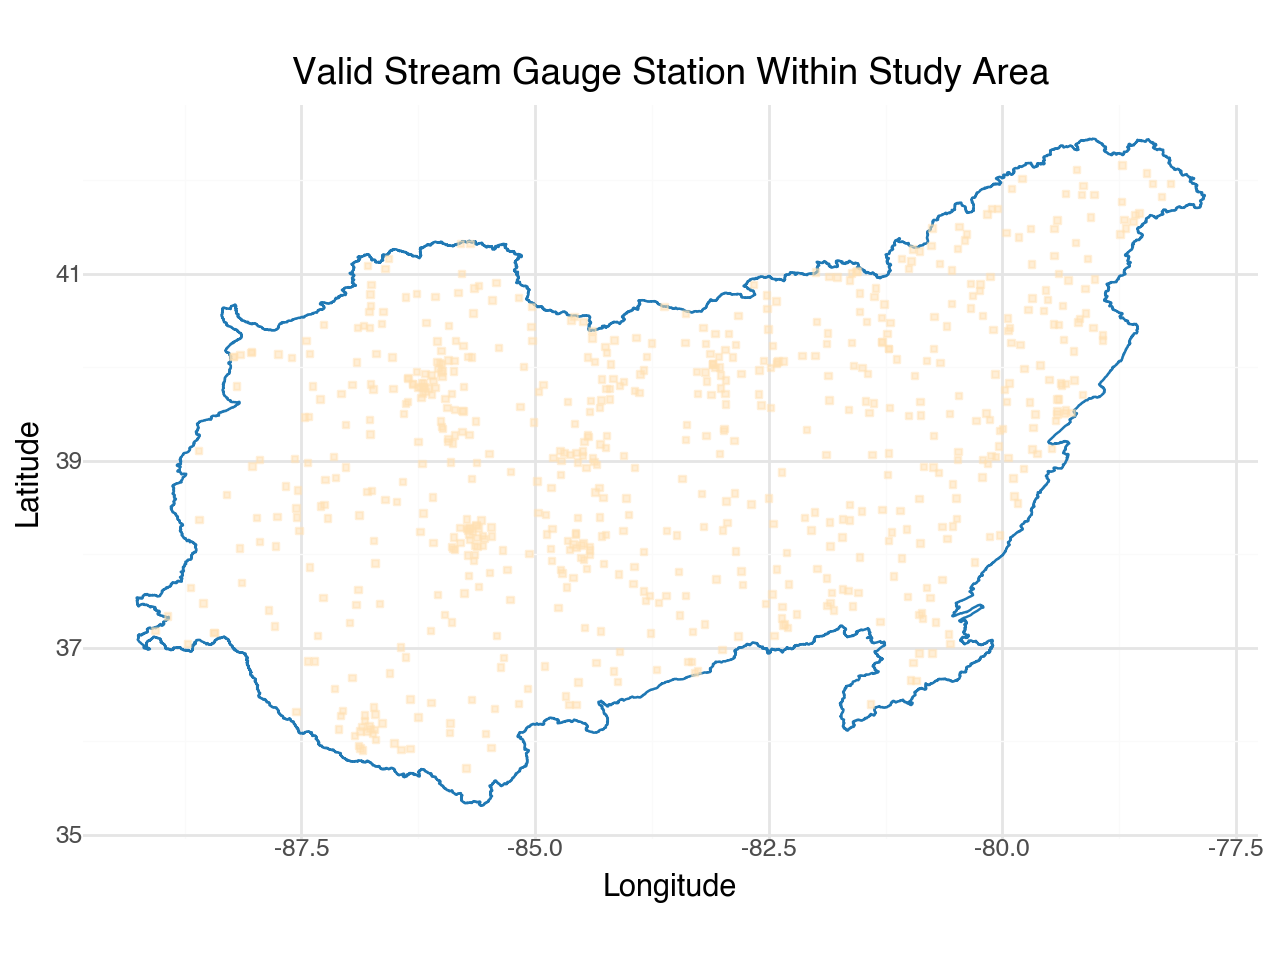

In [10]:
# Map: Location of Stream Gauging Stations
wsb_style = map_style.get('watershed_boundary')

# Load watershed boundaries
watershed_boundary_path = project_root_path / 'data' / 'silver' / 'geo' / 'gpkg' / 'study_area.gpkg'
wsd_boundary = gpd.read_file(watershed_boundary_path)

# Map
stram_gauging_stations_map = (
    ggplot()

    + geom_map(
        mapping=aes(geometry="geometry"),
        data=wsd_boundary,
        inherit_aes=False,
        color=wsb_style.get('color'),
        fill=None,
    )

    + geom_map(
        mapping=aes(geometry= "geometry"),
        data = valid_stns,
        shape = map_style.get('stream_gage').get('shape'),
        fill =  map_style.get('stream_gage').get('fill'),
        color =  map_style.get('stream_gage').get('fill'),
        size =0.8, 
        alpha = 0.5
    )
    + coord_fixed()
    + theme_minimal()
    + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
    + labs(title="Valid Stream Gauge Station Within Study Area", x="Longitude", y="Latitude")
)
stram_gauging_stations_map.show()

In [11]:
# Salve stations file
valid_stns_path = project_root_path / 'data/gold/geo/gpkg/study_area_stream_gauge_stn.gpkg'
valid_stns_path.parent.mkdir(parents=True, exist_ok=True)

valid_stns.to_file(valid_stns_path)
print(f"Streamflow stations saved to {valid_stns_path}")

Streamflow stations saved to /Users/alan/Data Science Projects/ML-ModClark-IUH-Model/data/gold/geo/gpkg/study_area_stream_gauge_stn.gpkg


#### Extract Geometry Points

In [82]:
stns_path = project_root_path / 'data/gold/geo/gpkg/study_area_stream_gauge_stn.gpkg'
stns = gpd.read_file(stns_path)
pour_points = pd.DataFrame(
    {'stn_id':stns['site_no'],
     'point': zip(stns.geometry.x, stns.geometry.y)}
)
pour_points.head()

,stn_id,point
0,03165000,"(-80.91924401050363, 36.64596267239885)"
1,03164000,"(-80.97896860805875, 36.64735109440792)"
2,03165500,"(-80.95258020228155, 36.83484669694608)"
3,03161000,"(-81.40694866174323, 36.39333625759056)"
4,03208500,"(-82.2957015627826, 37.20705645973639)"


## Watershed Delineation

This section of the notebook details and executes the methodology for automated watershed delineation. The process focuses on identifying and characterizing the contributing drainage areas for **707** valid stream gauging stations located across the Ohio Region. The derived watershed boundaries and their corresponding geomorphological characteristics will form the foundational input for training a machine learning model to estimate Time of Concentration ($T_c$) and Storage Coefficient ($R$) for ungauged watersheds, specifically for application within the ModClark model.

### Overview of the Watershed Delineation Process

The automated delineation of watershed boundaries from Digital Elevation Models (DEMs) involves a sequence of interconnected hydrological terrain analysis operations:

1.  **Compute Flow Direction:** This initial step involves deriving a grid where each cell's value indicates the direction water would flow out of that cell into one of its eight neighboring cells. This establishes the hydrological connectivity across the landscape.
2.  **Compute Flow Accumulation:** From the flow direction grid, a flow accumulation grid is computed. Each cell's value in this grid represents the total number of upstream cells that contribute flow to it. This effectively identifies areas of concentrated flow, such as streams and rivers, based on contributing area.
3.  **Snap Pour Point:** Stream gauging station coordinates, which serve as the watershed outlets (pour points), are typically obtained from raw datasets and may not align perfectly with the DEM-derived stream network due to spatial inaccuracies or differences in data resolution. The snapping process adjusts the original geographic coordinates of each gauge to the nearest cell that lies directly on the modeled stream network and meets a minimum flow accumulation threshold. This ensures the pour point is accurately positioned on a flow path for correct delineation.
4.  **Delineate Watershed:** Using the precisely snapped pour point and the computed flow direction grid, the contributing catchment area for each gauging station is then delineated. This process identifies all upstream cells that drain to the specified pour point, thereby defining the watershed boundary.

### DEM Data Preparation Prior to Delineation

Before initiating the core delineation process with tools like `PySheds`, the specific portions of the 1 arc-second resolution DEMs relevant to each watershed are queried from the Virtual Raster Tiles (VRTs) created in the preceding preprocessing notebook. During this querying process, certain preparatory steps are applied to ensure data integrity and continuity for hydrological analysis:

* **Filling Gaps:** Any small gaps or NoData values that may exist within the queried DEM window are filled based on the average values of their surrounding neighbors. This ensures a continuous elevation surface, which is crucial for uninterrupted flow path calculations.
* **Resolving Overlapping Areas:** When accessing data from VRTs that are composed of multiple overlapping tiles, any overlapping areas are resolved by selecting the first valid pixel value encountered. This is handled by default by `rasterio` and ensures a single, consistent elevation value for each location.

It is important to note that hydrological conditioning, specifically the filling of pits and depressions, was performed on individual DEM tiles prior to VRT creation in an earlier preprocessing step. This ensures the DEM is hydrologically connected and ready for accurate flow direction and accumulation computations in this notebook.

### Flow Direction Algorithms

The selection of an appropriate flow direction algorithm is critical for accurately representing water movement across the landscape. Three widely recognized algorithms include:

* **D8 (Deterministic 8):** This algorithm assigns flow from each cell to only one of its eight neighboring cells (cardinal or diagonal) based on the steepest descent. While simple and computationally efficient, it can oversimplify complex flow patterns, particularly in flat terrains or areas with divergent flow.
* **MFD (Multiple Flow Direction):** In contrast to D8, MFD distributes flow from each cell to multiple downslope neighbors proportionally based on their relative slopes. This better represents divergent flow paths and distributed runoff, but it may over-disperse flow paths in certain landscapes or at larger scales.
* **D-Infinity (D∞):** This algorithm assigns flow direction based on the steepest slope along a continuous range of angles (0-360 degrees), rather than being restricted to only eight discrete directions. It provides a more realistic representation of flow paths, especially in natural landscapes with subtle slope variations and complex topographies.

For this study, the **D8 (Deterministic 8)** algorithm has been selected for computing flow direction. This decision was primarily driven by its **computational simplicity and efficiency**, which proved to yield **consistently robust and effective watershed delineations** for the Ohio Region in preliminary testing. Despite its potential to oversimplify complex flow, its straightforward implementation provided optimal results.

### Importance of Snapping Pour Points

Following the computation of flow accumulation, the precise location of the watershed outlet (or 'pour point') is critical for accurate delineation. In raw datasets, stream gauging station coordinates often do not align perfectly with the DEM-derived stream network due to inherent spatial inaccuracies or differences in data resolution. The **snapping process** adjusts the original gauge coordinates to the nearest cell exhibiting a high flow accumulation, effectively ensuring that the pour point is precisely located on the modeled stream channel. This adjustment is vital for:

* Ensuring accurate alignment with the modeled hydrological flow paths derived from the DEM.
* Guaranteeing the correct and consistent delineation of the contributing watershed area for each gauge.

### Automated Snapping and Logging

To enhance robustness and minimize manual intervention, an **automated and iterative snapping approach** will be implemented for each pour point. This involves testing multiple flow accumulation thresholds to identify the nearest qualifying stream cell. A snapped point will be accepted only if the distance between its original and snapped coordinates falls within a **predefined acceptable spatial tolerance** (300 meters, which accounts for typical positional uncertainties and DEM resolution). If no suitable cell is found within this threshold for a given pour point, the event will be **logged as an anomaly** for subsequent manual review and investigation. All details of the snapping operations, including original and snapped coordinates, distances, thresholds tested, and anomaly flags, will be **systematically recorded** to ensure full traceability and uphold the scientific rigor of the data preparation process.

This automated watershed delineation workflow serves as a **critical preparatory step** for the broader objective of this project: developing a machine learning model capable of estimating ModClark's $T_c$ and $R$ parameters for ungauged watersheds in the Ohio Region, solely based on geomorphological characteristics derived from these delineated basins. The efficiency and consistency of this workflow are paramount for handling the **large number of stream gauges (707 in total)** and producing high-quality input data for the subsequent modeling phases of this scientific study.

In [83]:
from pyproj import Transformer
import rasterio
from pysheds.view import Raster, ViewFinder
import numpy as np
from scipy.ndimage import generic_filter

def get_raster_from_vrt(
    coord: tuple[float, float],
    vrt_path: str,
    up_stream_buffer_km: float = 30,
    down_stream_buffer_km: float = 1,
    coord_datum: str = "epsg:4269",  # NAD83
    fill_nodata: bool = True
) -> Raster:
    """
    Extracts a DEM subset from a VRT file given a coordinate and asymmetric buffer distance, and optionally fills NoData gaps.

    Parameters
    ----------
        coord (tuple[float, float]): Coordinate (lon, lat) in the specified `coord_datum` CRS.
        vrt_path (str): Path to the .vrt DEM file.
        up_stream_buffer_km (float): Buffer for top, left, and right.
        down_stream_buffer_km (float): Buffer for bottom.
        coord_datum (str): EPSG code of the input coordinate system. Default is 'epsg:4269' (NAD83).
        fill_nodata (bool): If True, fills NoData values using neighborhood averaging.

    Returns
    -------
        Raster: PySheds Raster.
    """
    with rasterio.open(vrt_path) as src:
        dem_crs = src.crs

        # Transform coordinates from coord_datum to DEM's CRS
        if coord_datum.lower() != str(dem_crs).lower():
            transformer = Transformer.from_crs(crs_from=coord_datum, crs_to=dem_crs, always_xy=True)
            x, y = transformer.transform(*coord)
        else:
            x, y = coord

        # Determine buffers (asymmetric)
        if dem_crs.is_projected:
            buffer_left = buffer_right = buffer_top = up_stream_buffer_km * 1000  # meters
            down_stream_buffer_km = down_stream_buffer_km * 1000  # meters
        else:
            km_to_deg = 1 / 111  # ~0.009 degrees per km
            buffer_left = buffer_right = buffer_top = up_stream_buffer_km * km_to_deg
            down_stream_buffer_km = down_stream_buffer_km * km_to_deg

        # Define asymmetric bounding box
        bounds = [x - buffer_left, y - down_stream_buffer_km, x + buffer_right, y + buffer_top]
        window = src.window(*bounds)

        array = src.read(1, window=window)
        transform = src.window_transform(window)
        shape = array.shape
        crs = src.crs
        nodata = src.nodata

        # Fill NoData values if requested
        if fill_nodata and nodata is not None:
            mask = array == nodata
            array = array.astype('float32')
            array[mask] = np.nan  # Replace NoData with NaN

            def mean_filter(values):
                center = values[len(values) // 2]
                if np.isnan(center):
                    return np.nanmean(values)
                return center

            filled = generic_filter(array, mean_filter, size=3, mode='nearest')
            array = np.where(np.isnan(array), filled, array)
            array = np.where(np.isnan(array), nodata, array)  # Reassign still-NaNs to nodata

        # Build viewfinder and return PySheds Raster
        view_finder = ViewFinder(
            affine=transform,
            shape=shape,
            crs=crs,
            nodata=nodata
        )

        raster = Raster(array, viewfinder=view_finder)
        return raster

In [84]:
# Get DEM example from VRT and coordinate of a pour point example
vrt_path = project_root_path /'data/silver/geo/raster/dem1arcsec_filled/dem1arcsec.vrt'
coord = pour_points.at[0,'point']

example_dem = get_raster_from_vrt(coord, vrt_path, up_stream_buffer_km=15, down_stream_buffer_km=15)

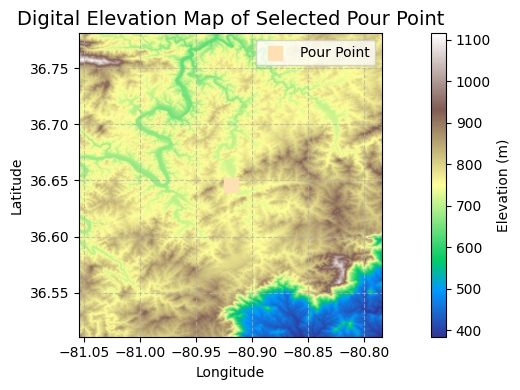

In [85]:
# Print Map of Retrieved DEM from VRT Windows
fig, ax = plt.subplots(figsize=(10,4)) # Slightly larger figure
fig.patch.set_alpha(0)

# Plot the elevation map
dem_im = plt.imshow(example_dem, extent=example_dem.extent, cmap='terrain', zorder=1)
plt.colorbar(dem_im, label='Elevation (m)')

plt.grid(zorder=0, linestyle='--', alpha=0.7)
plt.title('Digital Elevation Map of Selected Pour Point', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add Stream Gauge station
# Reduced size for better visual balance, and adding a label
pour_point_handle = plt.scatter(coord[0], coord[1], color=map_style.get('stream_gage').get('fill'),
                                 marker=map_style.get('stream_gage').get('shape'), s=100, zorder=3, label='Pour Point')


# Add a legend to explain markers
plt.legend(handles=[pour_point_handle], loc='upper right', fontsize=10)


plt.tight_layout()
# plt.savefig('improved_dem_map.png', dpi=300, bbox_inches='tight') # Uncomment to save the map
plt.show()

#### Flow Direction

In [86]:
# Flow Direction computation
grid = Grid.from_raster(example_dem)
fdir  = grid.flowdir(example_dem, routing='d8')
fdir

Raster([[-2, 16, 16, ...,  2,  2,  4],
        [64, 32, 16, ...,  2,  2,  4],
        [64, 64, 16, ...,  2,  2,  4],
        ...,
        [ 4,  4,  4, ...,  4,  8,  4],
        [ 4,  4,  4, ...,  4,  4,  4],
        [ 1,  1,  1, ..., -2, 16, 16]], shape=(973, 973))

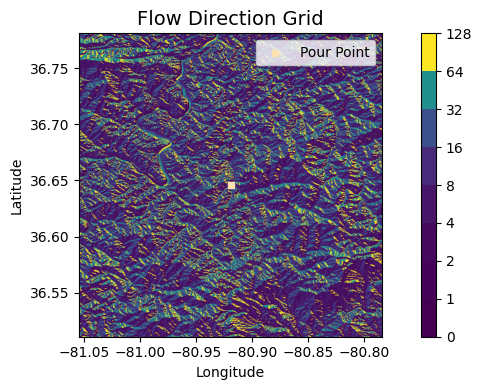

In [87]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
fig = plt.figure(figsize=(8,4))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
pour_point_handle = plt.scatter(coord[0], coord[1], color=map_style.get('stream_gage').get('fill'),
                                 marker=map_style.get('stream_gage').get('shape'), s=25, zorder=3, label='Pour Point')
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.legend(handles=[pour_point_handle], loc='upper right', fontsize=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Direction Grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()
plt.show()

#### Flow Accumulation

In [88]:
# Accumulation from flow dir
acc = grid.accumulation(fdir, routing='d8')
acc

Raster([[5.770e+02, 9.000e+01, 8.900e+01, ..., 1.000e+00, 1.000e+00,
         1.000e+00],
        [2.000e+00, 4.840e+02, 1.000e+00, ..., 1.000e+00, 2.000e+00,
         3.000e+00],
        [1.000e+00, 4.820e+02, 5.000e+00, ..., 2.000e+00, 2.000e+00,
         6.000e+00],
        ...,
        [2.000e+00, 2.000e+00, 2.000e+00, ..., 1.000e+00, 5.000e+00,
         7.000e+00],
        [3.000e+00, 3.000e+00, 3.000e+00, ..., 7.000e+00, 1.000e+00,
         8.000e+00],
        [4.000e+00, 8.000e+00, 1.200e+01, ..., 1.886e+03, 1.100e+01,
         9.000e+00]], shape=(973, 973))

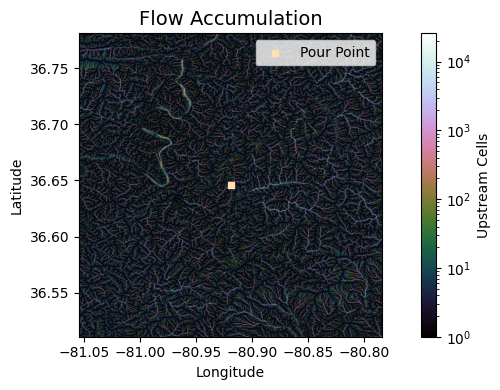

In [89]:
fig, ax = plt.subplots(figsize=(8,4))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
pour_point_handle = plt.scatter(coord[0], coord[1], color=map_style.get('stream_gage').get('fill'),
                                 marker=map_style.get('stream_gage').get('shape'), s=25, zorder=3, label='Pour Point')
plt.legend(handles=[pour_point_handle], loc='upper right', fontsize=10)

plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

#### Delineate Watershed

In [90]:
# Specify pour point
x, y = coord

# Delineate the catchment
catch = grid.catchment(x=x, y=y, fdir=fdir, xytype='coordinate', routing='d8')

# Plot the result
grid.clip_to(catch)
catch_view = grid.view(catch)
catch_view

Raster([[ True, False, False, False, False],
        [False,  True, False, False, False],
        [False, False,  True, False, False],
        [False, False, False,  True, False],
        [False, False, False, False,  True]])

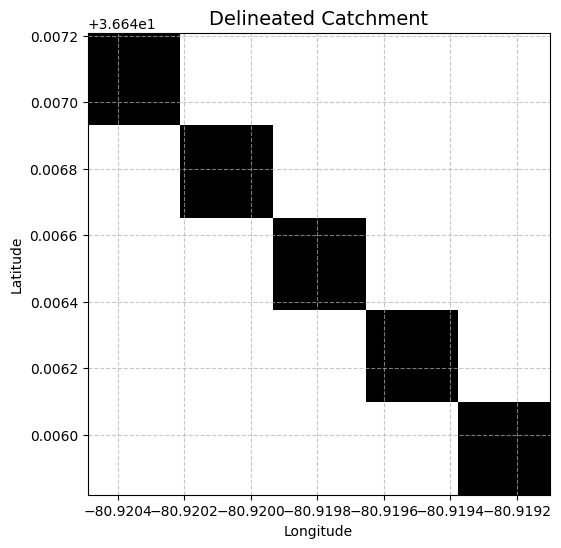

In [91]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid(True, zorder=0, linestyle='--', alpha=0.7)
im = ax.imshow(np.where(catch_view, catch_view, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)
plt.show()

Delineated watershed does not look right. I might be to incosistencies on geolocation of stations.  Below the same watershed is delineated with pour points snapped to different cell accumulation values: **50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000**.

In [92]:
def delineate_catchment_acc_value_test(accumulation_values):
    """
    Delineate and plot catchments for different accumulation thresholds in a fixed 3-column layout.

    Parameters:
    - accumulation_values: list of thresholds
    """
    num_plots = len(accumulation_values)
    ncols = 3
    nrows = math.ceil(num_plots / ncols)

    # Initialize figure with dynamic number of rows and fixed 3 columns
    fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 6 * nrows), sharey=True)
    fig.patch.set_alpha(0)

    # Flatten axes for easy iteration
    axes = axes.flatten()

    for idx, accumulation in enumerate(accumulation_values):
        # Load DEM and compute flow direction and accumulation
        grid = Grid.from_raster(example_dem)
        fdir = grid.flowdir(example_dem)
        acc = grid.accumulation(fdir, dirmap=dirmap)

        # Snap pour point to accumulation cell
        x_snap, y_snap = grid.snap_to_mask(mask=acc > accumulation, xy=coord)

        # Delineate the catchment
        catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')

        # Clip and view the catchment
        grid.clip_to(catch)
        clipped_catch = grid.view(catch)

        # Plot
        ax = axes[idx]
        ax.grid(True, zorder=0, linestyle='--', alpha=0.7)
        im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
                       zorder=1, cmap='Greys_r')

        pour_point_handle = ax.scatter(coord[0], coord[1], 
                                       color=map_style['stream_gage']['fill'],
                                       marker=map_style['stream_gage']['shape'], 
                                       s=50, zorder=3, label='Pour Point')

        pour_point_snapped = ax.scatter(x_snap, y_snap, color='Orange',
                                        marker='o', s=100, zorder=3, label='Snapped Pour Point')

        ax.legend(handles=[pour_point_handle, pour_point_snapped], loc='upper right', fontsize=10)
        ax.set_xlabel('Longitude')
        if idx % ncols == 0:
            ax.set_ylabel('Latitude')  # Only first column has y-label
        ax.set_title(f'Delineated Catchment (Acc > {accumulation})', size=14)

    # Hide unused subplots if any
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


Different Watershed Delineation of station id 03165000 with different accumulation values


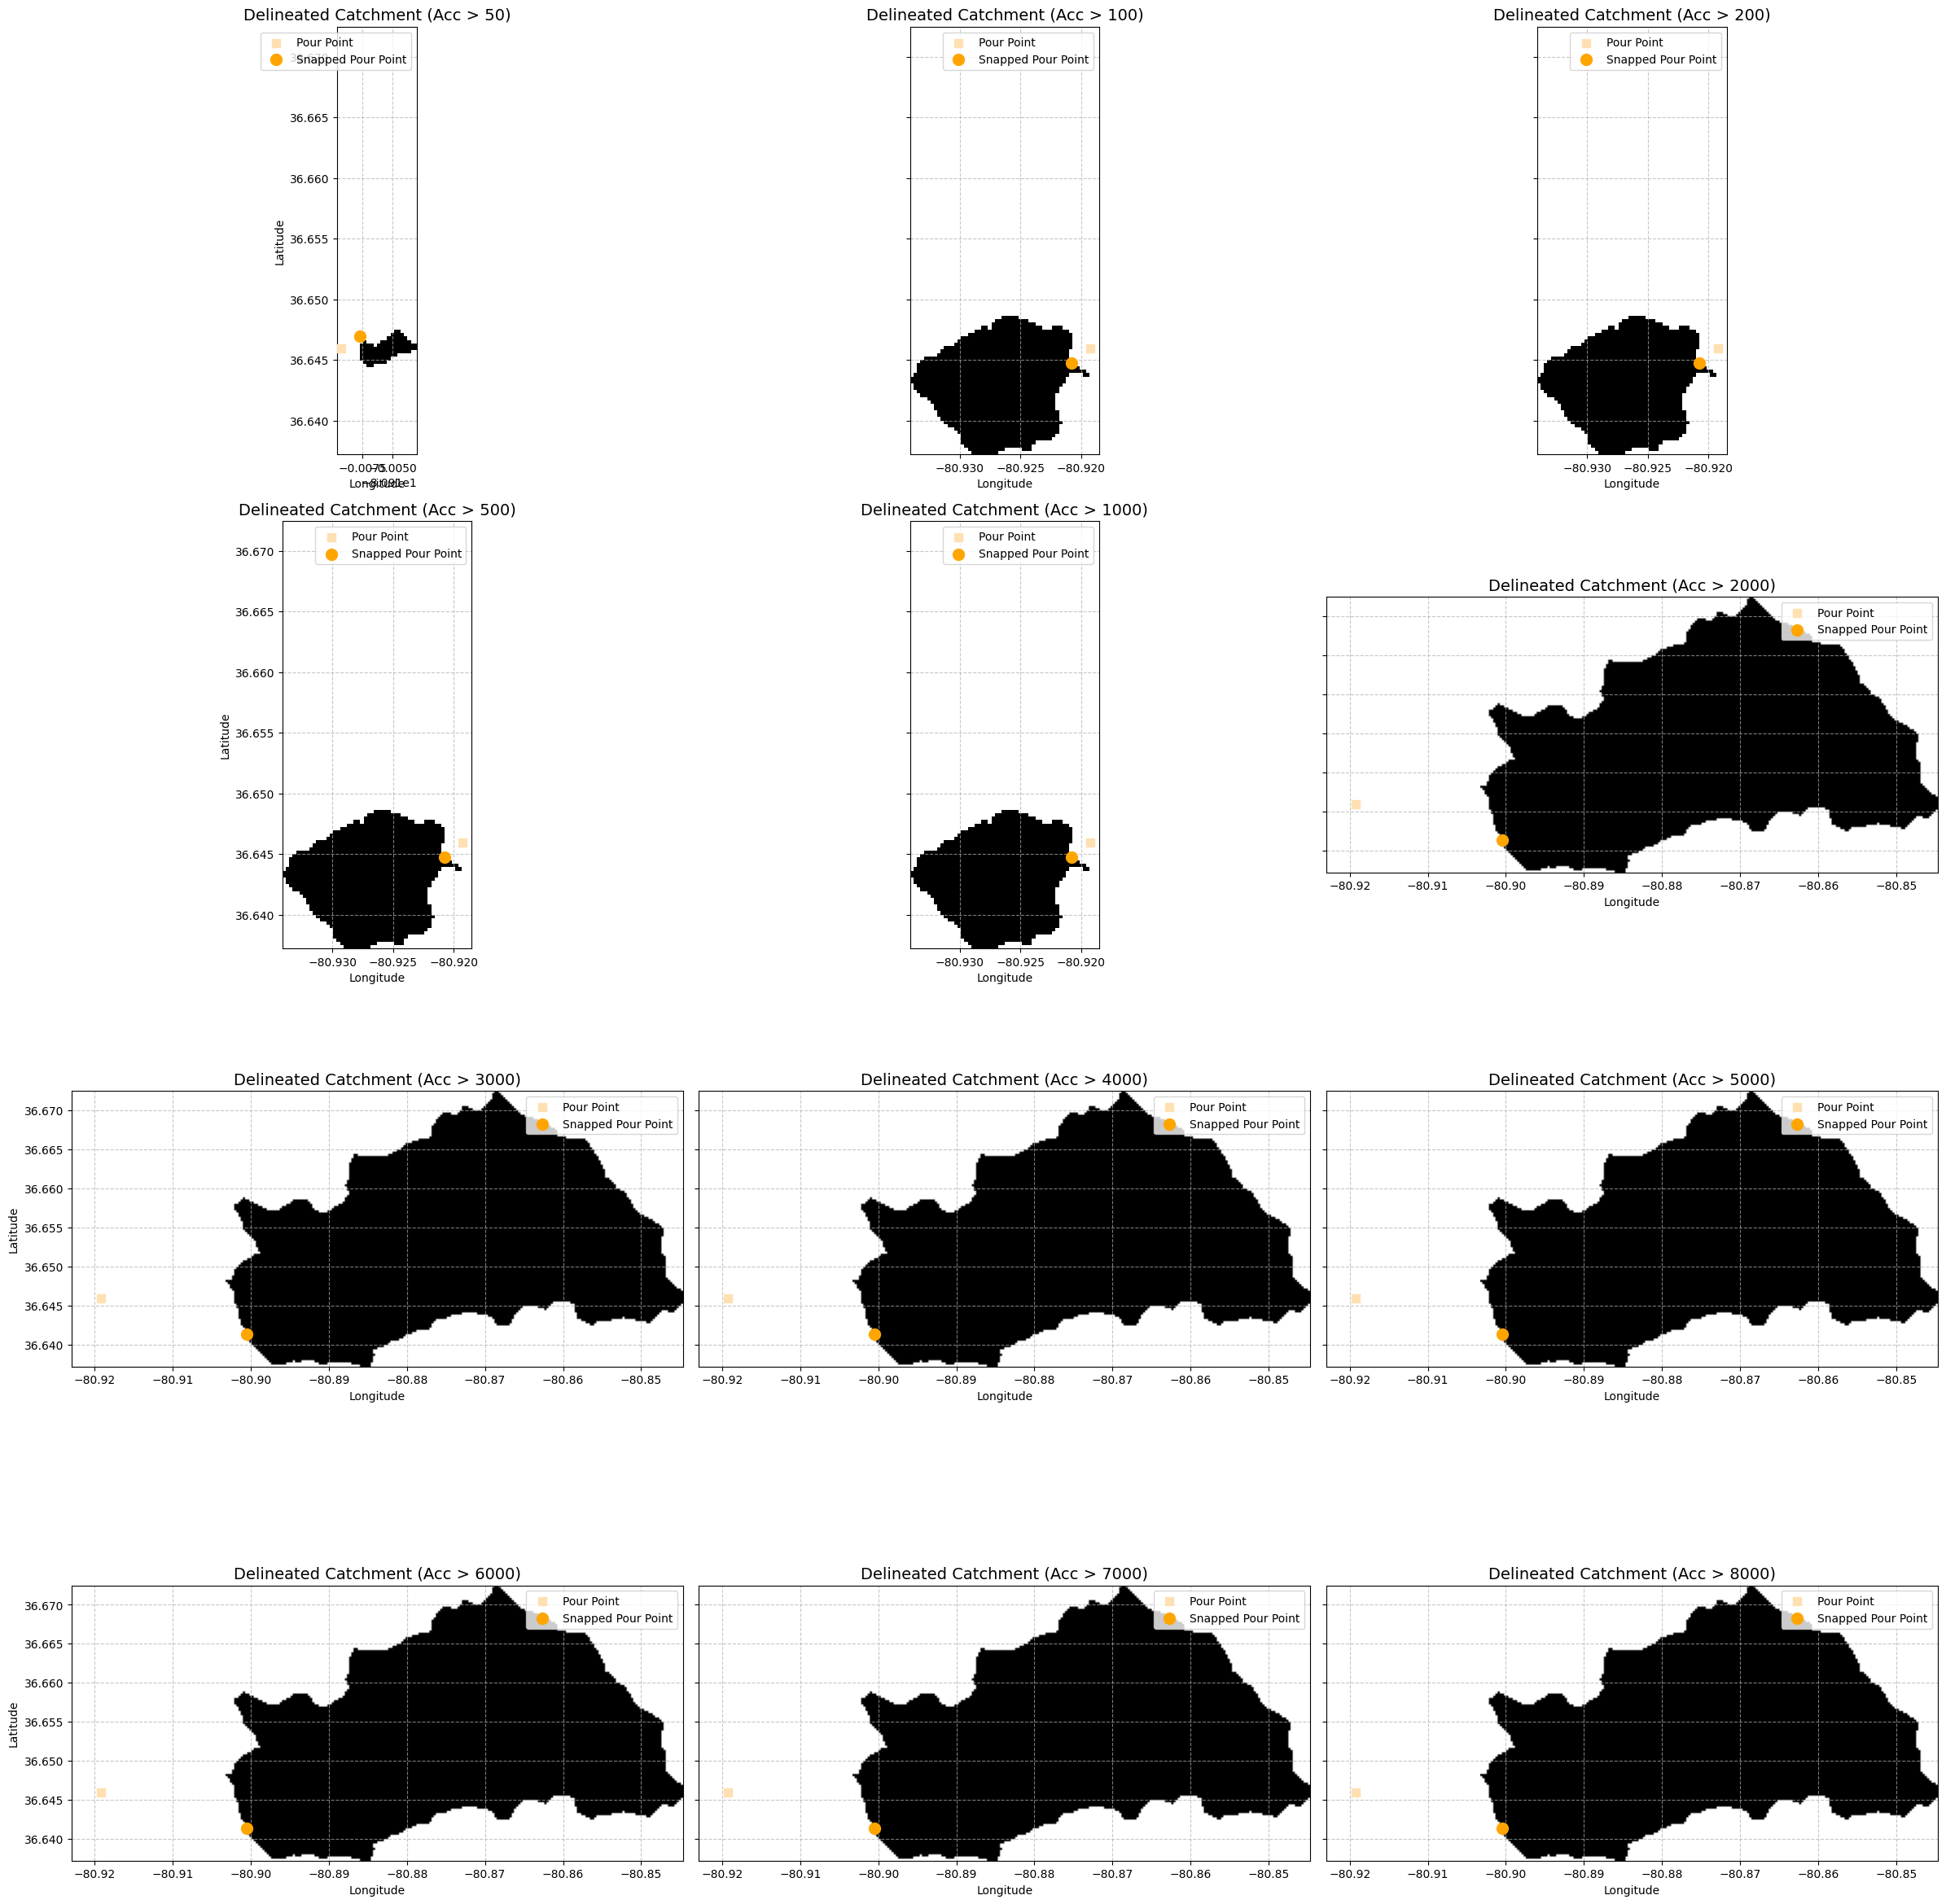

In [93]:
coord = pour_points.at[0,'point']
example_dem = get_raster_from_vrt(coord, vrt_path, up_stream_buffer_km=15)
accumulation_values = [50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
print(f"Different Watershed Delineation of station id {pour_points.at[0,'stn_id']} with different accumulation values")
delineate_catchment_acc_value_test(accumulation_values)


Visual inspection of preliminary delineation results, coupled with quantitative analysis of watershed characteristics, guided the selection of the optimal flow accumulation threshold for snapping pour points. When a threshold of **100 cells** was applied, the delineated watershed boundaries showed significant visual improvement, appearing more realistic in shape and extent at finer scales. Given that each 1 arc-second DEM cell corresponds to an approximate area of $900 \text{ m}^2$ ($0.0009 \text{ km}^2$), a threshold of 100 cells implies a minimum contributing area of $100 \times 900 \text{ m}^2 = 90,000 \text{ m}^2 = 0.09 \text{ km}^2$.

Conversely, increasing the threshold to **2000 cells** resulted in a minimum contributing area of $2000 \times 900 \text{ m}^2 = 1,800,000 \text{ m}^2 = 1.8 \text{ km}^2$ (approximately $0.7 \text{ mi}^2$). While this larger threshold yielded more hydrologically significant catchments, visual assessment indicated that the spatial displacement between the original observed pour point and its corresponding snapped location became notably larger.

To balance the necessity for hydrologically meaningful upstream contributing areas with the importance of maintaining spatial fidelity to the original stream gauge locations, a refined iterative snapping approach was implemented. This approach prioritizes the selection of a snapped pour point that generates a watershed with a minimum contributing area of at least **$1.8 \text{ km}^2$ (approximately $0.7 \text{ mi}^2$)**. Critically, this selection is constrained by the condition that the spatial distance between the original gauge location and the chosen snapped pour point must not exceed a predefined maximum acceptable threshold of **$500 \text{ meters}$**. If a specific threshold outputs an area of within the constraint but with avove limit in points distance, the imediately previous threshold will be considered. This dual-criterion methodology ensures that the delineated watersheds are both hydrologically representative and accurately tied to their observed measurement points.

#### Area and Distance Between Pour Original Points and Snapped Points

In [24]:
def delineate_watershed(raster, acc_threshold, coord):
    grid = Grid.from_raster(raster)
    fdir = grid.flowdir(raster)
    acc = grid.accumulation(fdir, dirmap=dirmap)

    # Snap pour point to accumulation cell
    x_snap, y_snap = grid.snap_to_mask(mask=acc > acc_threshold, xy=coord)
    snapped_coord = (x_snap, y_snap)

    # Delineate the catchment
    catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')

    # Clip and view the catchment
    grid.clip_to(catch)
    clipped_catch = grid.view(catch)

    return clipped_catch, grid, snapped_coord



In [25]:
def calculate_area_and_point_dist(grid, coord, snapped_points):
    # Convert catchment raster to vector geometry
    shapes = grid.polygonize()
    catchment_polygon = ops.unary_union([geometry.shape(shape)
                                        for shape, value in shapes])
    catchment_gse = gpd.GeoSeries(catchment_polygon, crs=grid.crs)
    projection = f"EPSG:{get_nad83_utm_epsg(catchment_gse)}"
    catchment_gse = catchment_gse.to_crs(projection)

    # Convert point to GeoDataFrame
    coords = [coord, snapped_points]
    points = [Point(coord) for coord in coords]
    point_gse = gpd.GeoSeries(points, crs=grid.crs)
    point_gse = point_gse.to_crs(projection)
    
    #Area and distance
    area = catchment_gse.area.iloc[0] / 1e6
    distance = point_gse.geometry[0].distance(point_gse.geometry[1])
    return area, distance

In [26]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
coord = pour_points.at[0,'point']
example_dem = get_raster_from_vrt(coord, vrt_path, up_stream_buffer_km=15)
catch, grid, snapped_points = delineate_watershed(example_dem, 100, coord)
area, distance = calculate_area_and_point_dist(grid, coord, snapped_points)

catch, grid, snapped_points = delineate_watershed(example_dem, 9000, coord)
area_2, distance_2 = calculate_area_and_point_dist(grid, coord, snapped_points)
print("Area of the catchment Accumulation Threshold = 1000: %.2f km². Distance between points: %.3f m" % (area, distance))
print("Area of the catchment Accumulation Threshold = 2000: %.2f km². Distance between points: %.3f m" % (area_2, distance_2))

Area of the catchment Accumulation Threshold = 1000: 1.05 km². Distance between points: 194.680 m
Area of the catchment Accumulation Threshold = 2000: 11.95 km². Distance between points: 1751.912 m


In [27]:
import preprocessing.delineate_watershed as dws

In [ ]:
# Get watershed
coord = pour_points.at[0,'point']
example_dem = dws.get_raster_from_vrt(coord, vrt_path, up_stream_buffer_km=15, down_stream_buffer_km=1)
catch, grid, snapped_points, fdir = dws.delineate_watershed_d8(example_dem, 1000, coord)
catch_gdf = dws.catchment_mask_to_gdf(grid, True, False)


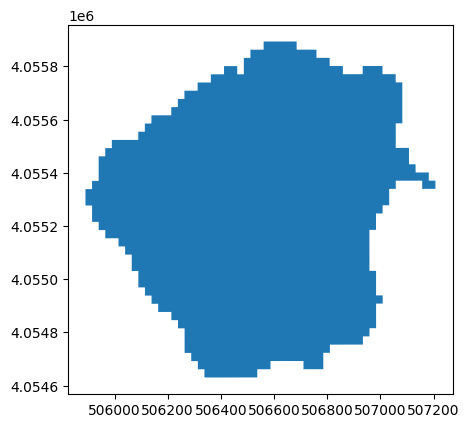

In [ ]:
catch_gdf.plot()
plt.show()

In [30]:
# Save flowdir raster
stnid = pour_points.at[0,'stn_id']
flowdir_path = project_root_path / 'data/silver/geo/raster/watersheds/' / f'flowdir_{stnid}.tif'
flowdir_path.parent.mkdir(parents=True, exist_ok=True)
try:
    dws.save_raster(flowdir_path, fdir, fdir.affine, fdir.crs)
    print(f"Flow direction raster saved to {flowdir_path}")
except Exception as e:
    print(f"Error saving flow direction raster: {e}")

Flow direction raster saved to /Users/alan/Data Science Projects/ML-ModClark-IUH-Model/data/silver/geo/raster/watersheds/flowdir_03165000.tif


In [ ]:
# Test saved flowdir raster
stnid = pour_points.at[0,'stn_id']
flowdir_path = project_root_path / 'data/silver/geo/raster/watersheds/' / f'flowdir_{stnid}.tif'

# Load the saved fdir raster
with rasterio.open(flowdir_path) as src:
    fdir = src.read(1)
    view_finder = ViewFinder(
                affine=src.transform,
                shape=fdir.shape,
                crs=src.crs,
                nodata=src.nodata
            )

raster = Raster(fdir, viewfinder=view_finder)
raster

Raster([[-2, 16, 16, ...,  2,  2,  4],
        [64, 32, 16, ...,  2,  2,  4],
        [64, 64, 16, ...,  2,  2,  4],
        ...,
        [64, 16, 16, ...,  8,  8,  8],
        [64, 16, 16, ...,  8,  8,  4],
        [-2, 16, 16, ..., 16, 16, 16]], shape=(519, 973), dtype=int32)

#### Batch Watershed Delineation

The following code delineates the watershed for the all stramgauge stations follwoing the steps:

1. Computes the optimum accumulation cell threshold
2. Saves the flow direction raster for later use
3. Saves the catchment mask for later use
4. Saves the a shape object of watershed boundaries along with station id, area, pour_point, snapped pour point and distance between snapped and pour point.

In [34]:
def add_info_to_geometry(gdf, stnid, area, pour_point, snapped_pour_point, distance_between_points, accumulation_value):
    if len(gdf) != 1:
        raise ValueError("GeoDataFrame must have exactly one row.")

    gdf['stnid'] = stnid
    gdf['area'] = area
    gdf['pour_point_nad83'] = Point(pour_point)
    gdf['snapped_pour_point_nad83'] = Point(snapped_pour_point)
    gdf['distance_between_points_m'] = distance_between_points
    gdf['accumulation_value'] = accumulation_value

    return gdf

def compute_distance_and_area(coord, snapped_point, grid, catch_gdf):
    projection = catch_gdf.crs
    points = [Point(coord), Point(snapped_point)]
    point_gse = gpd.GeoSeries(points, crs=grid.crs).to_crs(projection)
    distance = point_gse.geometry[0].distance(point_gse.geometry[1])
    catch_area = catch_gdf.area.iloc[0] / 1e6
    return distance, catch_area

catch_raster_path = project_root_path / 'data/silver/geo/raster/watersheds/'
catch_gpkg_path = project_root_path / 'data/silver/geo/gpkg/watersheds/'
catch_gpkg_path.mkdir(parents=True, exist_ok=True)
catch_raster_path.mkdir(parents=True, exist_ok=True)

stn_ids = list(pour_points['stn_id'])
pour_points_list = list(pour_points['point'])

vrt_path = project_root_path / 'data/silver/geo/raster/dem1arcsec_filled/dem1arcsec.vrt'
acc_values = [50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
distance_threshold_m = 500
area_threshold_km2 = 1.8

failed_log = []
log_path = project_root_path / 'data/log/watershed_delineation_log.txt'
log_path.parent.mkdir(parents=True, exist_ok=True)

for stnid, coord in tqdm(zip(stn_ids, pour_points_list), desc=f"Processing stations", total=len(stn_ids)):

    flowdir_path = catch_raster_path / f'flowdir_{stnid}.tif'
    catch_path = catch_raster_path / f'catchment_{stnid}.tif'
    catch_gdf_path = catch_gpkg_path / f'catchment_{stnid}.gpkg'

    try:
        dem = dws.get_raster_from_vrt(coord, vrt_path, up_stream_buffer_km=15, down_stream_buffer_km=15)
    except Exception as e:
        failed_log.append((stnid, coord, str(e)))
        continue

    candidates = []

    for count_acc, acc in enumerate(acc_values):
        try:
            catch, grid, snapped_points, fdir = dws.delineate_watershed_d8(dem, acc, coord)
            catch_gdf = dws.catchment_mask_to_gdf(grid, True, False)
            distance, catch_area = compute_distance_and_area(coord, snapped_points, grid, catch_gdf)

            # Store candidate within distance threshold for possible later use
            if distance <= distance_threshold_m:
                candidates.append({
                    'acc': acc,
                    'catch': catch,
                    'grid': grid,
                    'snapped_points': snapped_points,
                    'fdir': fdir,
                    'catch_gdf': catch_gdf,
                    'distance': distance,
                    'area': catch_area
                })

            if distance <= distance_threshold_m and catch_area >= area_threshold_km2:
                dws.save_raster(catch_path, catch, catch.affine, catch.crs)
                dws.save_raster(flowdir_path, fdir, fdir.affine, fdir.crs)

                catch_gdf_info = add_info_to_geometry(catch_gdf,stnid, catch_area, coord, snapped_points, distance, acc)
                catch_gdf_info.to_file(catch_gdf_path, driver='GPKG')
                break

            elif catch_area >= area_threshold_km2 and distance > distance_threshold_m and count_acc > 0:
                prev_acc = acc_values[count_acc - 1]
                catch, grid, snapped_points, fdir = dws.delineate_watershed_d8(dem, prev_acc, coord)
                catch_gdf = dws.catchment_mask_to_gdf(grid, True, False)

                distance, catch_area = compute_distance_and_area(coord, snapped_points, grid, catch_gdf)

                dws.save_raster(catch_path, catch, catch.affine, catch.crs)
                dws.save_raster(flowdir_path, fdir, fdir.affine, fdir.crs)

                catch_gdf_info = add_info_to_geometry(catch_gdf,stnid, catch_area, coord, snapped_points, distance, prev_acc)
                catch_gdf_info
                catch_gdf_info.to_file(catch_gdf_path, driver='GPKG')
                break

            # If last acc value reached and none satisfied, check for best candidate within distance threshold
            if count_acc == len(acc_values) - 1:
                if candidates:
                    best_candidate = max(candidates, key=lambda x: x['area'])

                    dws.save_raster(catch_path, best_candidate['catch'], best_candidate['catch'].affine, best_candidate['catch'].crs)
                    dws.save_raster(flowdir_path, best_candidate['fdir'], best_candidate['fdir'].affine, best_candidate['fdir'].crs)

                    catch_gdf_info = add_info_to_geometry(
                        best_candidate['catch_gdf'],
                        stnid,
                        best_candidate['area'],
                        coord,
                        best_candidate['snapped_points'],
                        best_candidate['distance'],
                        best_candidate['acc']
                    )
                    catch_gdf_info.to_file(catch_gdf_path, driver='GPKG')
                else:
                    failed_log.append((stnid, coord, f"No suitable catchment within distance threshold"))
                # inside outermost loop after all processing for stnid
            
            # Clean up
            del catch, grid, snapped_points, fdir, catch_gdf
            gc.collect()

        except Exception as e:
            failed_log.append((stnid, coord, str(e)))
            
    # Clean up
    del dem
    del candidates
    gc.collect()

with  open(log_path, 'w') as f:
    for stnid, coord, error in failed_log:
        f.write(f"Station ID: {stnid}, Coordinate: {coord}, Error: {error}\n")


Processing stations:   0%|          | 0/707 [00:00<?, ?it/s]

#####  Verify Errs in Delineated Watershed

In [108]:
log_path = project_root_path / 'data/log/watershed_delineation_log.txt'
# Read the log file
with open(log_path, 'r') as f:
    log_data = f.readlines()
errs = [err.split(', ')[3] for err in log_data]
print(f'Number of failed delineation: {len(errs)}')
set(errs)

Number of failed delineation: 140


{'Error: index 0 is out of bounds for axis 0 with size 0\n'}

The `IndexError: index 0 is out of bounds for axis 0 with size 0` occurs in the pysheds library when the `snap_to_mask` method tries to access an index in an empty array (tree_xy). This happens because no valid cells in the accumulation raster (`acc`) exceed the specified `acc_threshold`, resulting in an empty mask. 

It means that, it was tried to meet the criteria of area and distance between points and none of previous accumulation values (`[50, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]`) meet could delineate a watershed satisfying the criteria of area and distance, and the current in loop fails since there is no cell above the current accumulation value. 

Therefore those it failed to delineate watershed for those 140 stations. 

An example watershed is delineated below to confirm the err. 

In [139]:
errs_stnid = [err.split(', ')[0].split(': ')[1] for err in log_data]
errs_pour_point = [tuple(map(float, point_err.split(': ')[2].split(', Error')[0].replace('(','').replace(')','').split(', '))) for point_err in log_data]

Area of the catchment: 0.7396778276238901 km². Distance between points: 975.8635423524134 m
Geometry falls entirely in UTM Zone 17
Reprojecting to EPSG:26917...


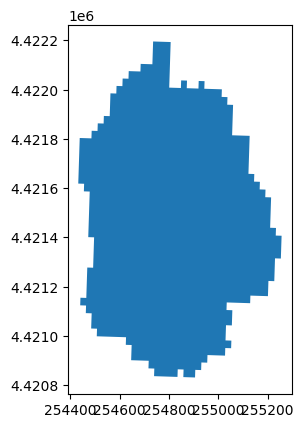

In [140]:
# Get watershed
coord = errs_pour_point[0]
example_dem = dws.get_raster_from_vrt(coord, vrt_path, up_stream_buffer_km=15, down_stream_buffer_km=15)
catch, grid, snapped_points, fdir = dws.delineate_watershed_d8(example_dem, 1000, coord)
distance, catch_area = compute_distance_and_area(coord, snapped_points, grid, catch_gdf)
print(f"Area of the catchment: {catch_area} km². Distance between points: {distance} m")
catch_gdf = dws.catchment_mask_to_gdf(grid, True, True)
catch_gdf.plot()
plt.show()

The next value in the accumulation loop fails, and the one above delineated a watershed not big enough with points farther above the limit.